In [6]:
import pandas as pd

# 1) Load the dataset
df = pd.read_csv('/content/water_potability.csv')

# 2) Inspect shape and info
print("Dataset shape:", df.shape)
print("\nColumn info:")
print(df.info())

# 3) Count missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Dataset shape: (3276, 10)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None

Missing values per column:
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potabilit

In [7]:
from sklearn.impute import SimpleImputer

# 1) Specify the imputer for median strategy
median_imputer = SimpleImputer(strategy='median')

# 2) Apply it to the columns with missing values
cols_to_impute = ['ph', 'Sulfate', 'Trihalomethanes']
df[cols_to_impute] = median_imputer.fit_transform(df[cols_to_impute])

# 3) Verify that there are no more missing values
print("Missing values after imputation:")
print(df[cols_to_impute].isnull().sum())


Missing values after imputation:
ph                 0
Sulfate            0
Trihalomethanes    0
dtype: int64


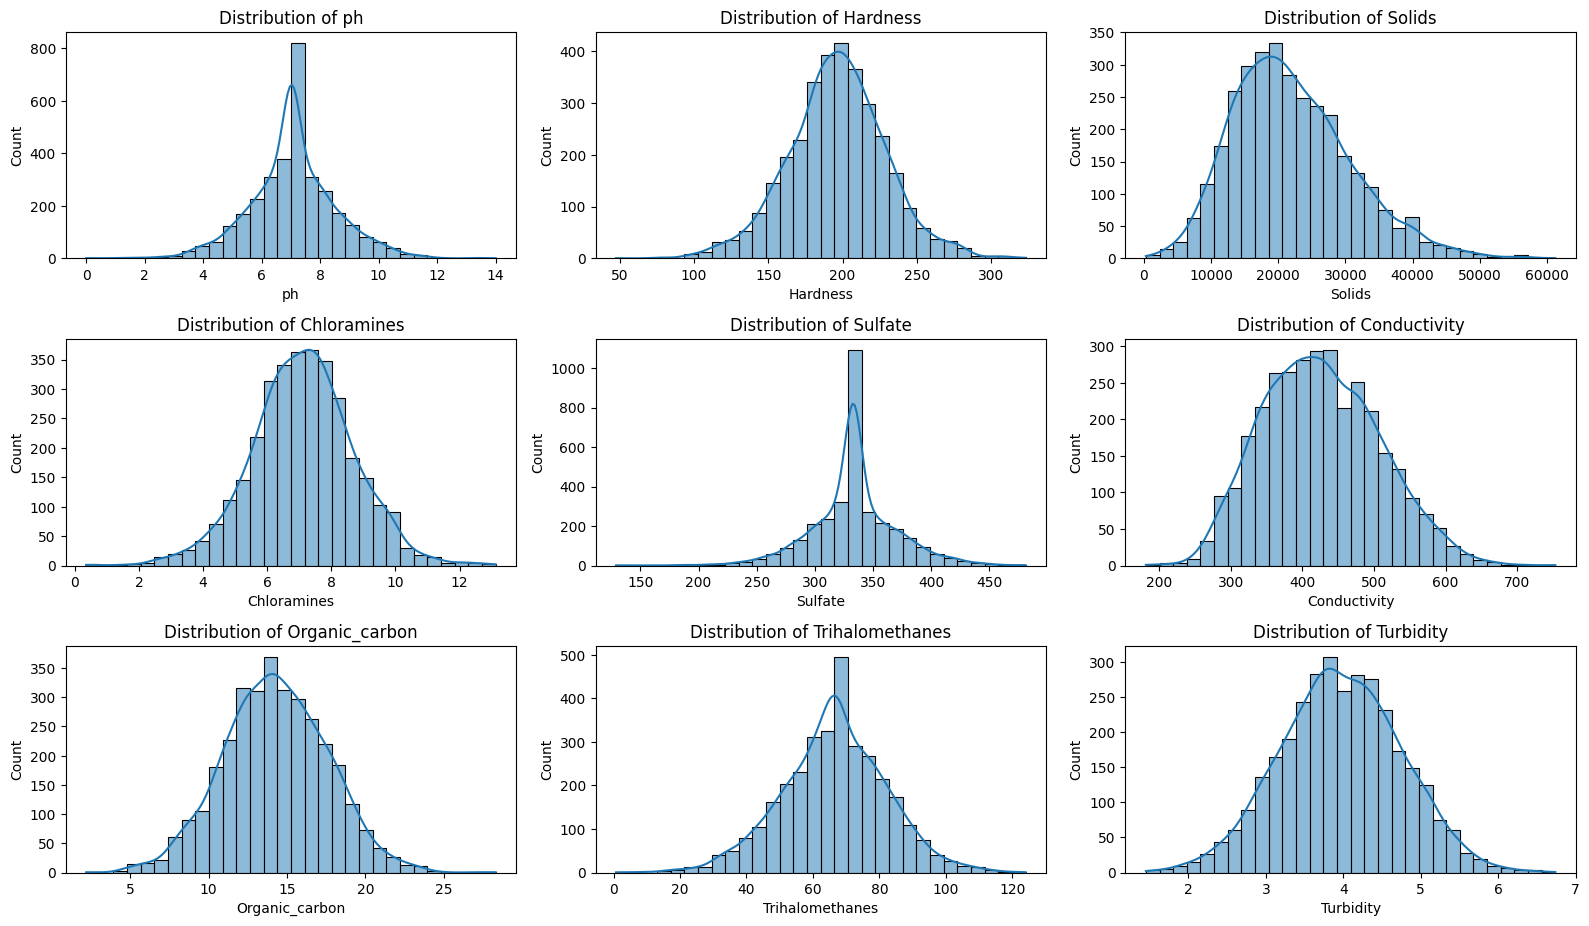

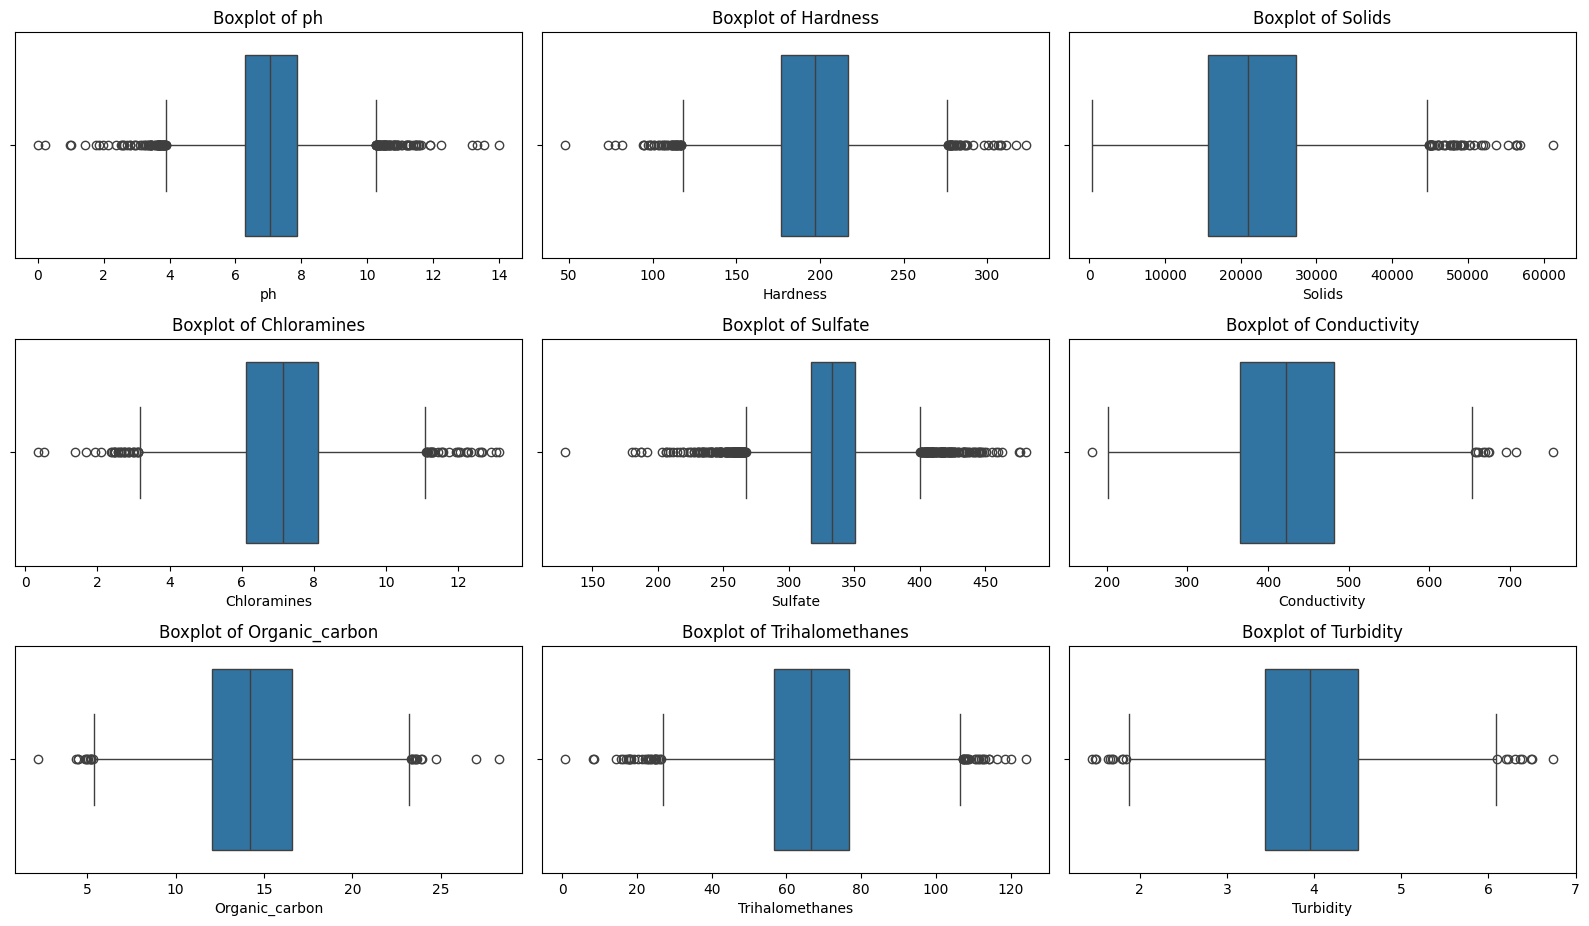

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Features to visualize (exclude target)
features = ['ph', 'Hardness', 'Solids', 'Chloramines',
            'Sulfate', 'Conductivity', 'Organic_carbon',
            'Trihalomethanes', 'Turbidity']

# 1) Histograms with KDE
plt.figure(figsize=(16, 12))
for i, col in enumerate(features, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 2) Boxplots for outlier detection
plt.figure(figsize=(16, 12))
for i, col in enumerate(features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


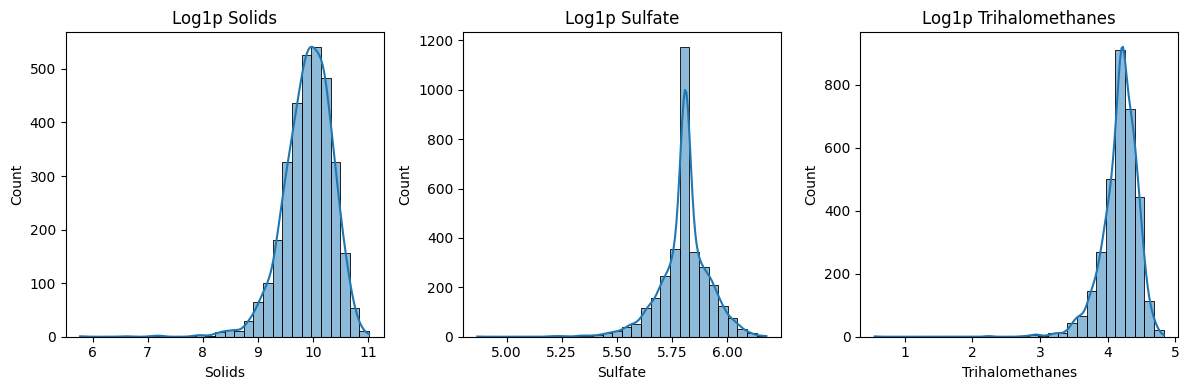

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Create a copy and log1p-transform the skewed cols
df_log = df.copy()
for col in ['Solids', 'Sulfate', 'Trihalomethanes']:
    df_log[col] = np.log1p(df_log[col])

# 2) Plot the transformed distributions
plt.figure(figsize=(12, 4))
for i, col in enumerate(['Solids', 'Sulfate', 'Trihalomethanes'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df_log[col], kde=True, bins=30)
    plt.title(f'Log1p {col}')
plt.tight_layout()
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.55      0.60       400
           1       0.45      0.57      0.50       256

    accuracy                           0.56       656
   macro avg       0.56      0.56      0.55       656
weighted avg       0.58      0.56      0.56       656

ROC AUC Score:  0.5624316406250001


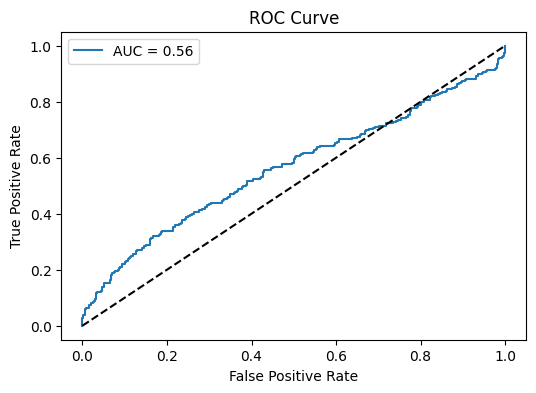

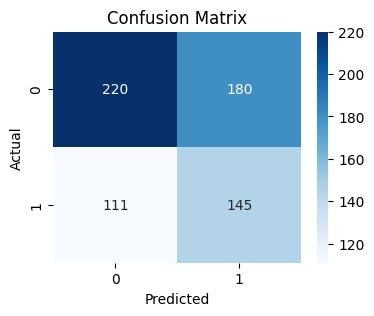

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Prepare X & y
X = df_log.drop('Potability', axis=1)
y = df_log['Potability']

# 2) Split (stratify to keep class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 4) Train Logistic Regression
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_scaled, y_train)

# 5) Make predictions & probabilities
y_pred  = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# 6) Classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_proba))

# 7) Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 8) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.83      0.75       400
           1       0.61      0.41      0.49       256

    accuracy                           0.67       656
   macro avg       0.65      0.62      0.62       656
weighted avg       0.66      0.67      0.65       656

Random Forest ROC AUC: 0.68041015625


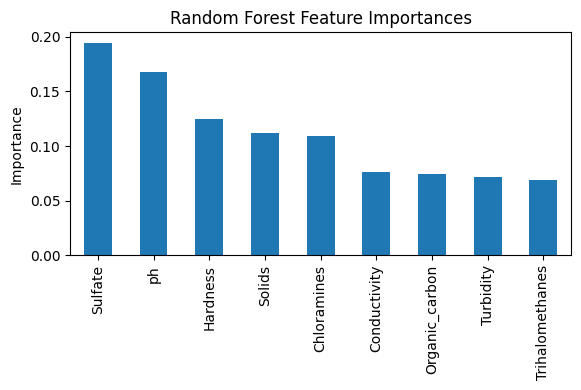

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

# 1) Prepare train/test splits (reuse X_train, X_test, y_train, y_test from before,
# but built from df_log without scaling)
X = df_log.drop('Potability', axis=1)
y = df_log['Potability']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2) Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 3) Predictions & AUC
y_pred_rf  = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))
print("Random Forest ROC AUC:", roc_auc_score(y_test, y_proba_rf))

# 4) Plot feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(6,4))
importances.plot(kind='bar')
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


Before SMOTE: Potability
0    1598
1    1022
Name: count, dtype: int64
After  SMOTE: Potability
0    1598
1    1598
Name: count, dtype: int64

--- SMOTE + RF Classification Report ---
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       400
           1       0.52      0.55      0.54       256

    accuracy                           0.63       656
   macro avg       0.61      0.61      0.61       656
weighted avg       0.63      0.63      0.63       656

SMOTE + RF ROC AUC: 0.67841796875


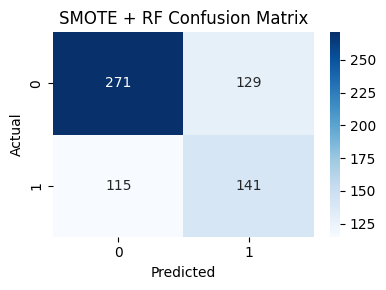

In [13]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Apply SMOTE to the TRAIN split
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After  SMOTE:", y_train_sm.value_counts())

# 2) Retrain Random Forest on the balanced data
rf_sm = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
rf_sm.fit(X_train_sm, y_train_sm)

# 3) Evaluate on the original TEST set
y_pred_sm  = rf_sm.predict(X_test)
y_proba_sm = rf_sm.predict_proba(X_test)[:, 1]

print("\n--- SMOTE + RF Classification Report ---")
print(classification_report(y_test, y_pred_sm))
print("SMOTE + RF ROC AUC:", roc_auc_score(y_test, y_proba_sm))

# 4) Confusion Matrix
cm_sm = confusion_matrix(y_test, y_pred_sm)
plt.figure(figsize=(4,3))
sns.heatmap(cm_sm, annot=True, fmt="d", cmap="Blues")
plt.title("SMOTE + RF Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:58:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.64      0.66       400
           1       0.49      0.55      0.52       256

    accuracy                           0.61       656
   macro avg       0.59      0.60      0.59       656
weighted avg       0.61      0.61      0.61       656

XGBoost ROC AUC: 0.643544921875


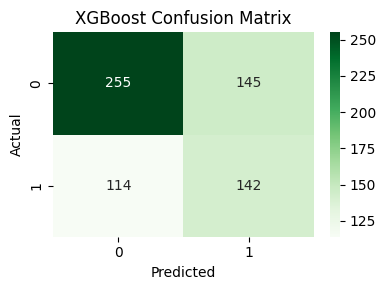

In [14]:
# If you haven’t already installed XGBoost, uncomment the next line:
# !pip install xgboost

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Instantiate XGBoost (with a scale_pos_weight to handle imbalance)
scale_pw = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pw,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 2) Fit on SMOTE data
xgb_clf.fit(X_train_sm, y_train_sm)

# 3) Predict on original test set
y_pred_xgb  = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# 4) Print metrics
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost ROC AUC:", roc_auc_score(y_test, y_proba_xgb))

# 5) Plot confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(4,3))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [17]:
import numpy as np
import pandas as pd
import joblib

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# 1) Define
skewed_cols = ['Solids', 'Sulfate', 'Trihalomethanes']

# 2) Fit and save the median imputer
X_full = df.drop('Potability', axis=1)
y_full = df['Potability']

imputer = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imputer.fit_transform(X_full), columns=X_full.columns)
joblib.dump(imputer, 'imputer.joblib')

# 3) Apply log1p to just the skewed columns and save that list
X_imp[skewed_cols] = np.log1p(X_imp[skewed_cols])
joblib.dump(skewed_cols, 'skewed_cols.joblib')

# 4) Fit and save the scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)
joblib.dump(scaler, 'scaler.joblib')

# 5) SMOTE‐balance & train the RF
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_scaled, y_full)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_bal, y_bal)
joblib.dump(rf, 'rf_model.joblib')

print("Saved: imputer.joblib, skewed_cols.joblib, scaler.joblib, rf_model.joblib")


Saved: imputer.joblib, skewed_cols.joblib, scaler.joblib, rf_model.joblib


In [19]:
!pip install streamlit pyngrok


In [20]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

def main():
    imputer     = joblib.load('imputer.joblib')
    skewed_cols = joblib.load('skewed_cols.joblib')
    scaler      = joblib.load('scaler.joblib')
    rf_model    = joblib.load('rf_model.joblib')

    df_raw   = pd.read_csv('water_potability.csv')
    features = df_raw.columns.drop('Potability')
    defaults = df_raw.median()
    mins     = df_raw.min()
    maxs     = df_raw.max()

    st.set_page_config(page_title="💧 Water Potability Predictor", layout="centered")
    st.title("💧 Water Potability Predictor")
    st.write("Adjust metrics below and click **Predict**.")

    user_vals = {}
    for feat in features:
        user_vals[feat] = st.number_input(
            feat,
            min_value=float(mins[feat]),
            max_value=float(maxs[feat]),
            value=float(defaults[feat]),
            format="%.2f"
        )

    if st.button("Predict Potability"):
        inp = pd.DataFrame([user_vals])
        inp_imp = pd.DataFrame(imputer.transform(inp), columns=inp.columns)
        for c in skewed_cols:
            inp_imp[c] = np.log1p(inp_imp[c])
        inp_scaled = scaler.transform(inp_imp)
        proba = rf_model.predict_proba(inp_scaled)[0,1]
        verdict = "SAFE 💚" if proba >= 0.5 else "UNSAFE 🚩"
        st.markdown(f"### **{verdict}**  (Prob: {proba:.1%})")
        st.subheader("Feature Importances")
        imps = pd.Series(rf_model.feature_importances_, index=features).sort_values()
        st.bar_chart(imps)

if __name__=="__main__":
    main()


Writing app.py
